In [19]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime, timedelta
from scipy.integrate import odeint
import os
from tqdm import tqdm

In [20]:
plot_df = pd.read_csv("data/final_data.csv")
plot_df = plot_df.reset_index()
plot_df 

,index,date,temp,mass,prec
0,0,02-04,0.48,0.000000,2.126420
1,1,02-05,0.48,65.030000,2.183341
2,2,02-06,0.48,-47.023333,2.219349
3,3,02-07,0.48,-159.076667,2.255356
4,4,02-08,0.48,-271.130000,2.291364
...,...,...,...,...,...
255,255,23-07,0.77,-7700.080000,2.338623
256,256,23-08,0.79,-7768.790000,2.364702
257,257,23-09,0.82,-7857.560000,2.383863
258,258,23-10,0.85,-7982.470000,2.319903


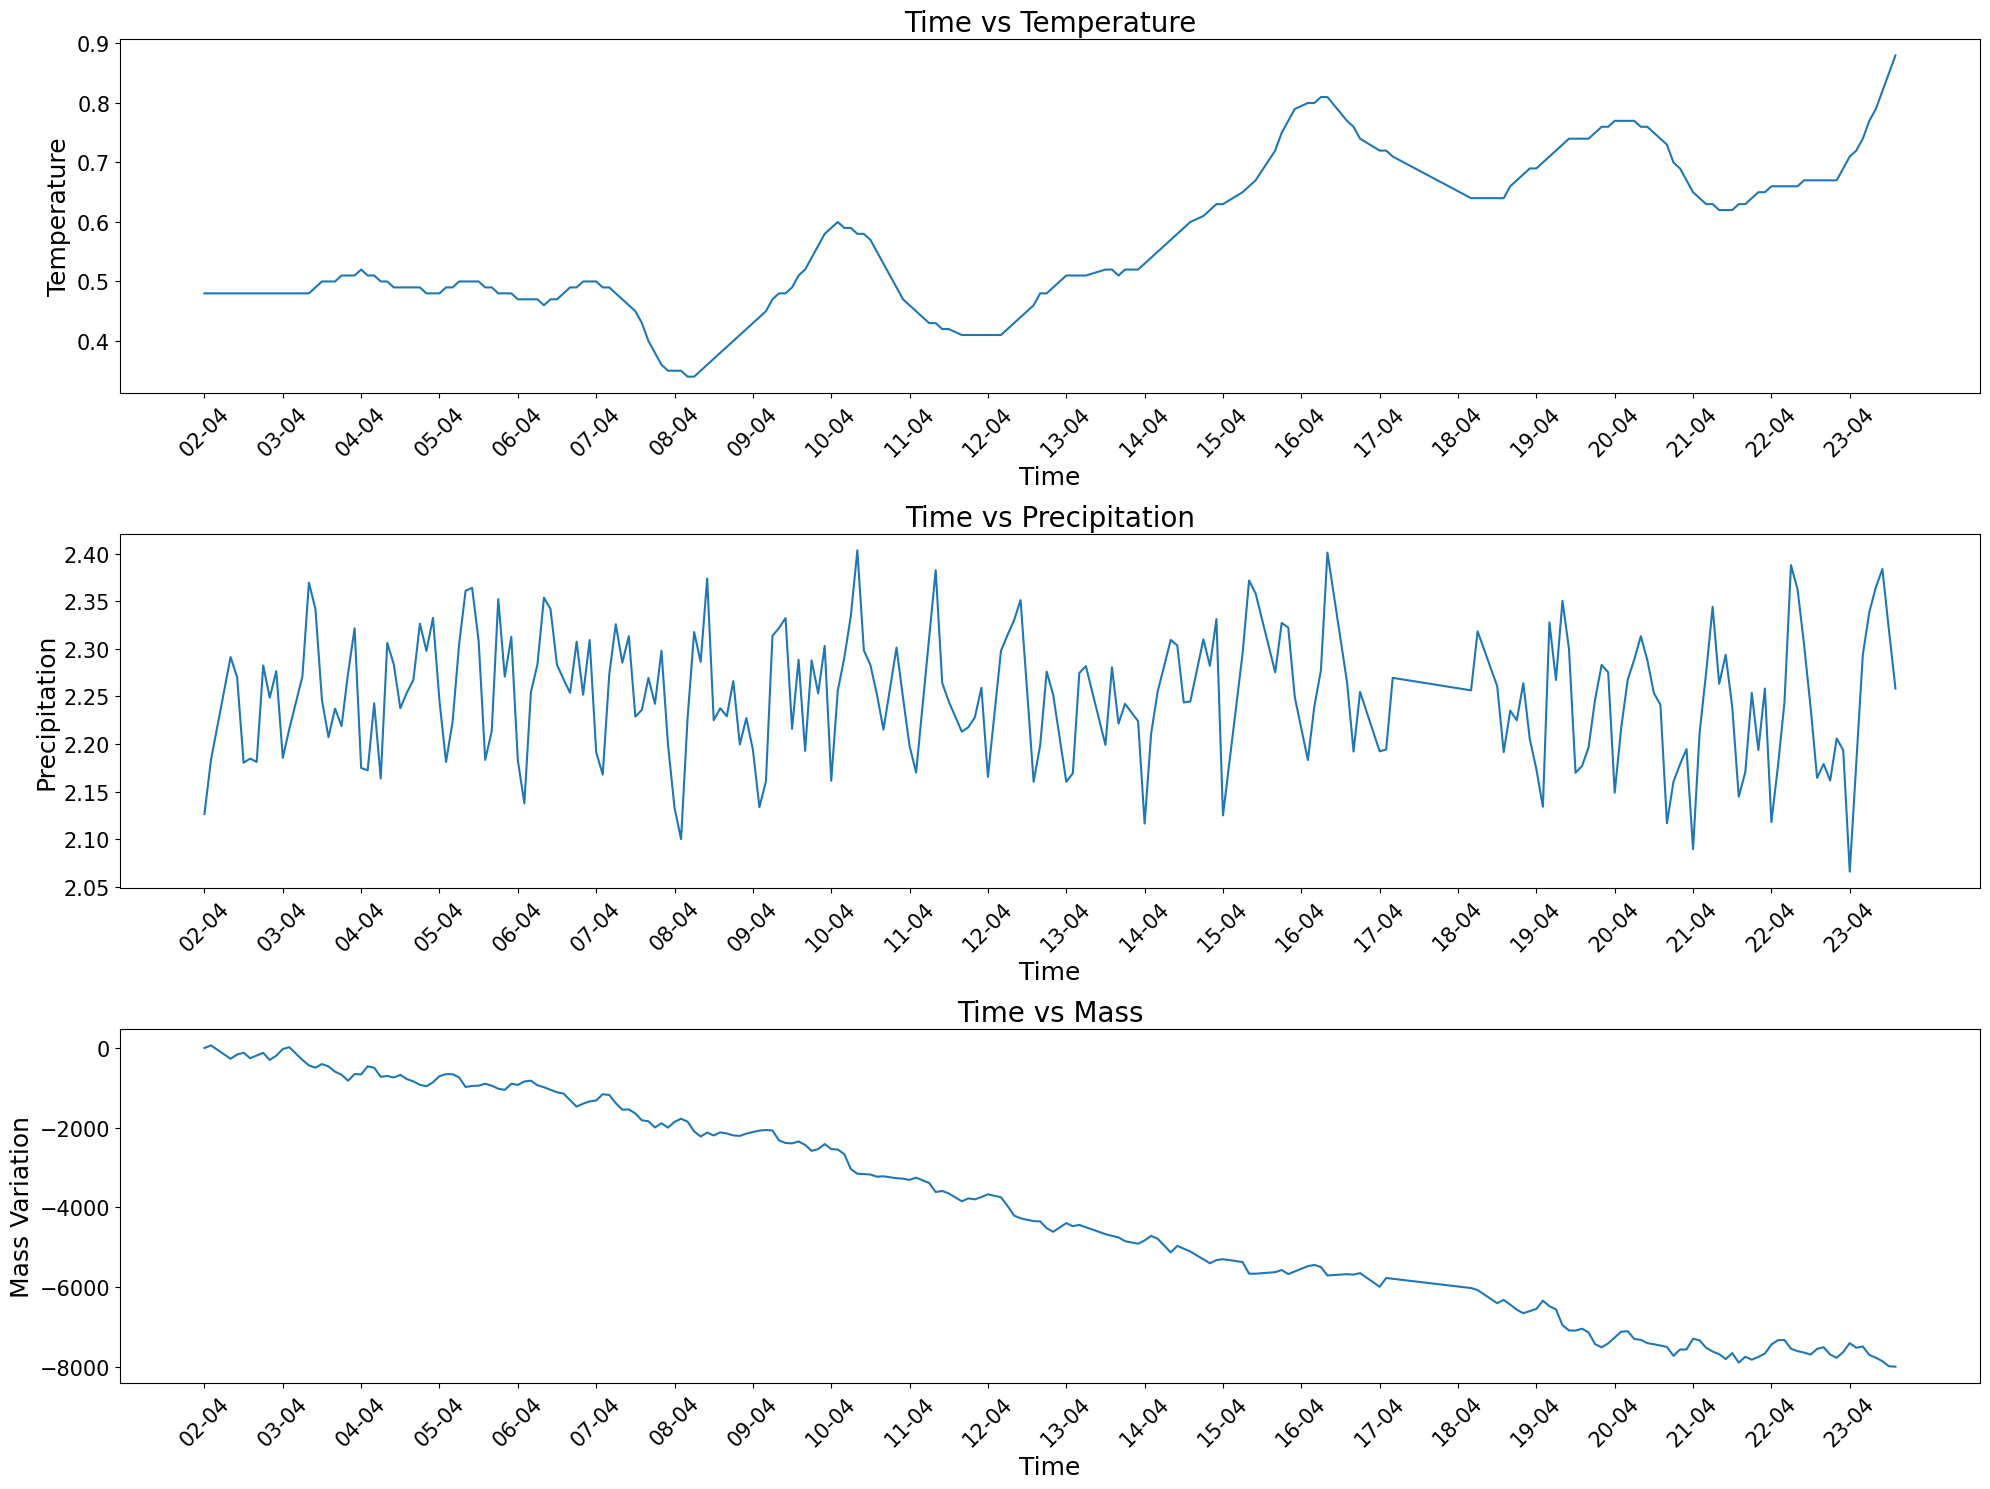

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots(3, 1, figsize=(20, 15))

# Date vs Temperature
ax[0].plot(plot_df['date'], plot_df['temp'])
ax[0].set_xlabel('Time', fontsize=18)
ax[0].set_ylabel('Temperature', fontsize=18)
ax[0].set_title('Time vs Temperature', fontsize=20)
ax[0].set_xticks(plot_df['date'][::12])
ax[0].set_xticklabels(plot_df['date'][::12], rotation=45, fontsize=15)
ax[0].tick_params(axis='y', labelsize=15)

# Date vs Precipitation
ax[1].plot(plot_df['date'], plot_df['prec'])
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Precipitation', fontsize=18)
ax[1].set_title('Time vs Precipitation', fontsize=20)
ax[1].set_xticks(plot_df['date'][::12])
ax[1].set_xticklabels(plot_df['date'][::12], rotation=45, fontsize=15)
ax[1].tick_params(axis='y', labelsize=15)

# Date vs Mass
ax[2].plot(plot_df['date'], plot_df['mass'])
ax[2].set_xlabel('Time', fontsize=18)
ax[2].set_ylabel('Mass Variation', fontsize=18)
ax[2].set_title('Time vs Mass', fontsize=20)
ax[2].set_xticks(plot_df['date'][::12])
ax[2].set_xticklabels(plot_df['date'][::12], rotation=45, fontsize=15)
ax[2].tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()


In [22]:
def loss_function(prediction, actual):
    loss = 0
    for idx in range(len(prediction)):
        loss += np.abs(prediction[idx] - actual[idx])
    return loss

def mean_loss_function(prediction, actual):
    loss = []
    for idx in range(len(prediction)):
        loss.append(np.abs(prediction[idx] - actual[idx]))
    return np.mean(loss)

def MSE_loss_function(prediction, actual):
    loss = []
    for idx in range(len(prediction)):
        loss.append((prediction[idx] - actual[idx]) ** 2)
    return np.mean(loss)

# Constants
specific_heat_capacity_ice_kJ_per_kg_K = 2.1  # kJ kg^-1 K^-1
latent_heat_of_fusion_ice_kJ_per_kg = 334  # kJ kg^-1
# Mass in gigatonnes (Gt)
mass_in_gt = 1  # Example for 1 Gt
mass_in_kg = mass_in_gt * 10**12  # Convert Gt to kg
heat_capacity_for_1Gt_ice_kJ_per_K = specific_heat_capacity_ice_kJ_per_kg_K * mass_in_kg
# Latent heat of fusion for 1 Gt of ice
latent_heat_of_fusion_for_1Gt_ice_kJ = latent_heat_of_fusion_ice_kJ_per_kg * mass_in_kg

# k_t_m = 0.0014 # This is an example value for the heat transfer coefficient
k_t_m = 0.0003
C_ice = heat_capacity_for_1Gt_ice_kJ_per_K  # Example value for the heat capacity of ice (J/kg*K)
T_0 = 0  # Reference temperature (K), assuming 0°C in Kelvin
L_f = latent_heat_of_fusion_for_1Gt_ice_kJ  # Latent heat of fusion for ice (J/kg)
C_water = 4.186 * mass_in_kg
M0 = 28900000  # Initial mass (Gt), example value

In [23]:
# Time span (months)
t_span = (0, 260)
t_eval = np.linspace(*t_span, 260)

def temperature(t):
    return 0.48 + 0.25 * np.sin(np.pi * t / 12) + 0.01 * t / 12 # Sinusoidal variation of temperature

def precipitation(t):
    return 2.25 + 0.2 * np.cos(np.pi * t / 3)

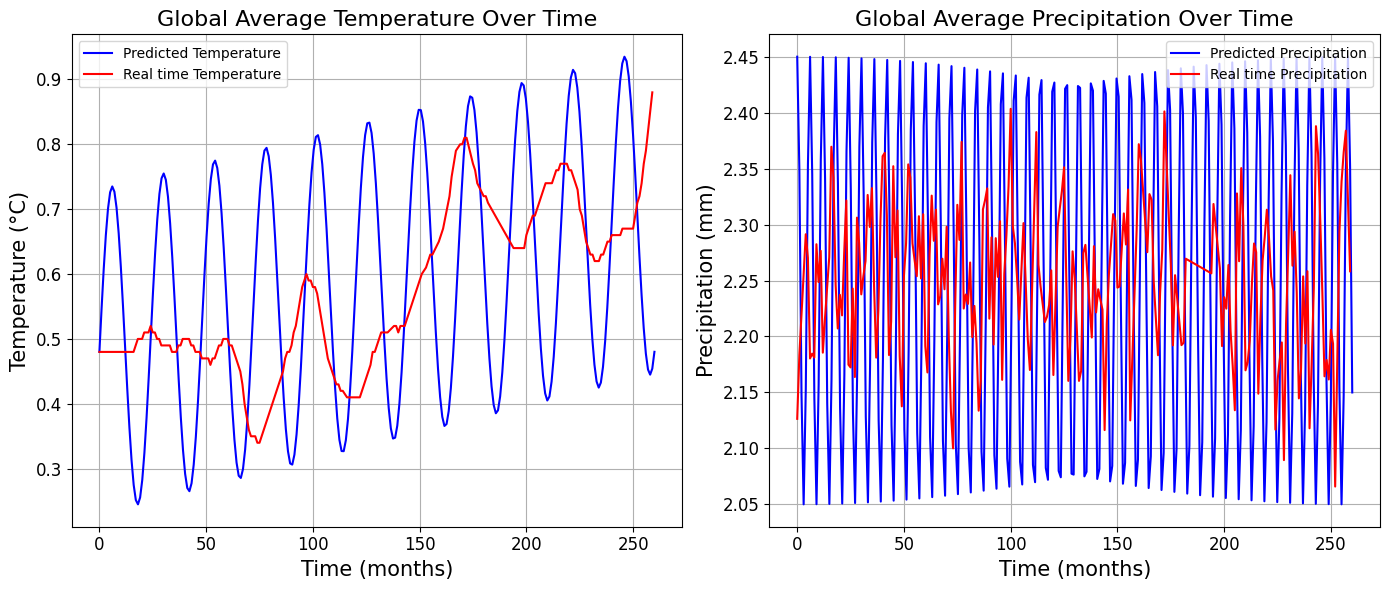

In [24]:
temperatures = temperature(t_eval)
precipitations = precipitation(t_eval)

# Plotting
plt.figure(figsize=(14, 6))

# Temperature plot
plt.subplot(1, 2, 1)
plt.plot(t_eval, temperatures, label='Predicted Temperature', color='blue')
plt.plot(plot_df['index'], plot_df['temp'], label='Real time Temperature', color='red')
plt.xlabel('Time (months)', fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=15)
plt.title('Global Average Temperature Over Time', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend()

# Precipitation plot
plt.subplot(1, 2, 2)
plt.plot(t_eval, precipitations, label='Predicted Precipitation', color='blue')
plt.plot(plot_df['index'], plot_df['prec'], label='Real time Precipitation', color='red')
plt.xlabel('Time (months)', fontsize=15)
plt.ylabel('Precipitation (mm)', fontsize=15)
plt.title('Global Average Precipitation Over Time', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Other parameters remain the same
T_f, T_m = 0, 0  # Temperature thresholds (°C)
P_f, P_m = 2.1, 2.3

# Model functions
def dMdt_TCF(t, M):  # Temperature-Caused Formation
    T = temperature(t)
    return k_f / (1 + np.exp(4 * (T - T_f))) * M if T < T_f else 0

def dMdt_TCM(t, M):  # Temperature-Caused Melting
    T = temperature(t)
    return -k_m * 2 * (T - T_m) * np.log(M) if T > T_m else 0

def dMdt_PCF(t, M):  # Precipitation-Caused Formation
    P = precipitation(t)
    return k_p * (P) / M if P < P_f else 0

def dMdt_PCM(t, M):  # Precipitation-Caused Melting
    P = precipitation(t)
    return -k_pm * (P * (1 / np.log(M)))  if P > P_m else 0

# Combined model
def dMdt_combined(t, M):
    return (dMdt_TCF(t, M) + dMdt_TCM(t, M) + 
            dMdt_PCF(t, M) + dMdt_PCM(t, M))

# Solving each model
M0 = [28900000]  # Initial glacier mass

In [26]:
def solve_model(k_f, k_m, k_p, k_pm):

    sol_TCF = solve_ivp(dMdt_TCF, t_span, M0, t_eval=t_eval)
    sol_TCM = solve_ivp(dMdt_TCM, t_span, M0, t_eval=t_eval)
    sol_PCF = solve_ivp(dMdt_PCF, t_span, M0, t_eval=t_eval)
    sol_PCM = solve_ivp(dMdt_PCM, t_span, M0, t_eval=t_eval)
    sol_combined = solve_ivp(dMdt_combined, t_span, M0, t_eval=t_eval)

    return sol_TCF, sol_TCM, sol_PCF, sol_PCM, sol_combined


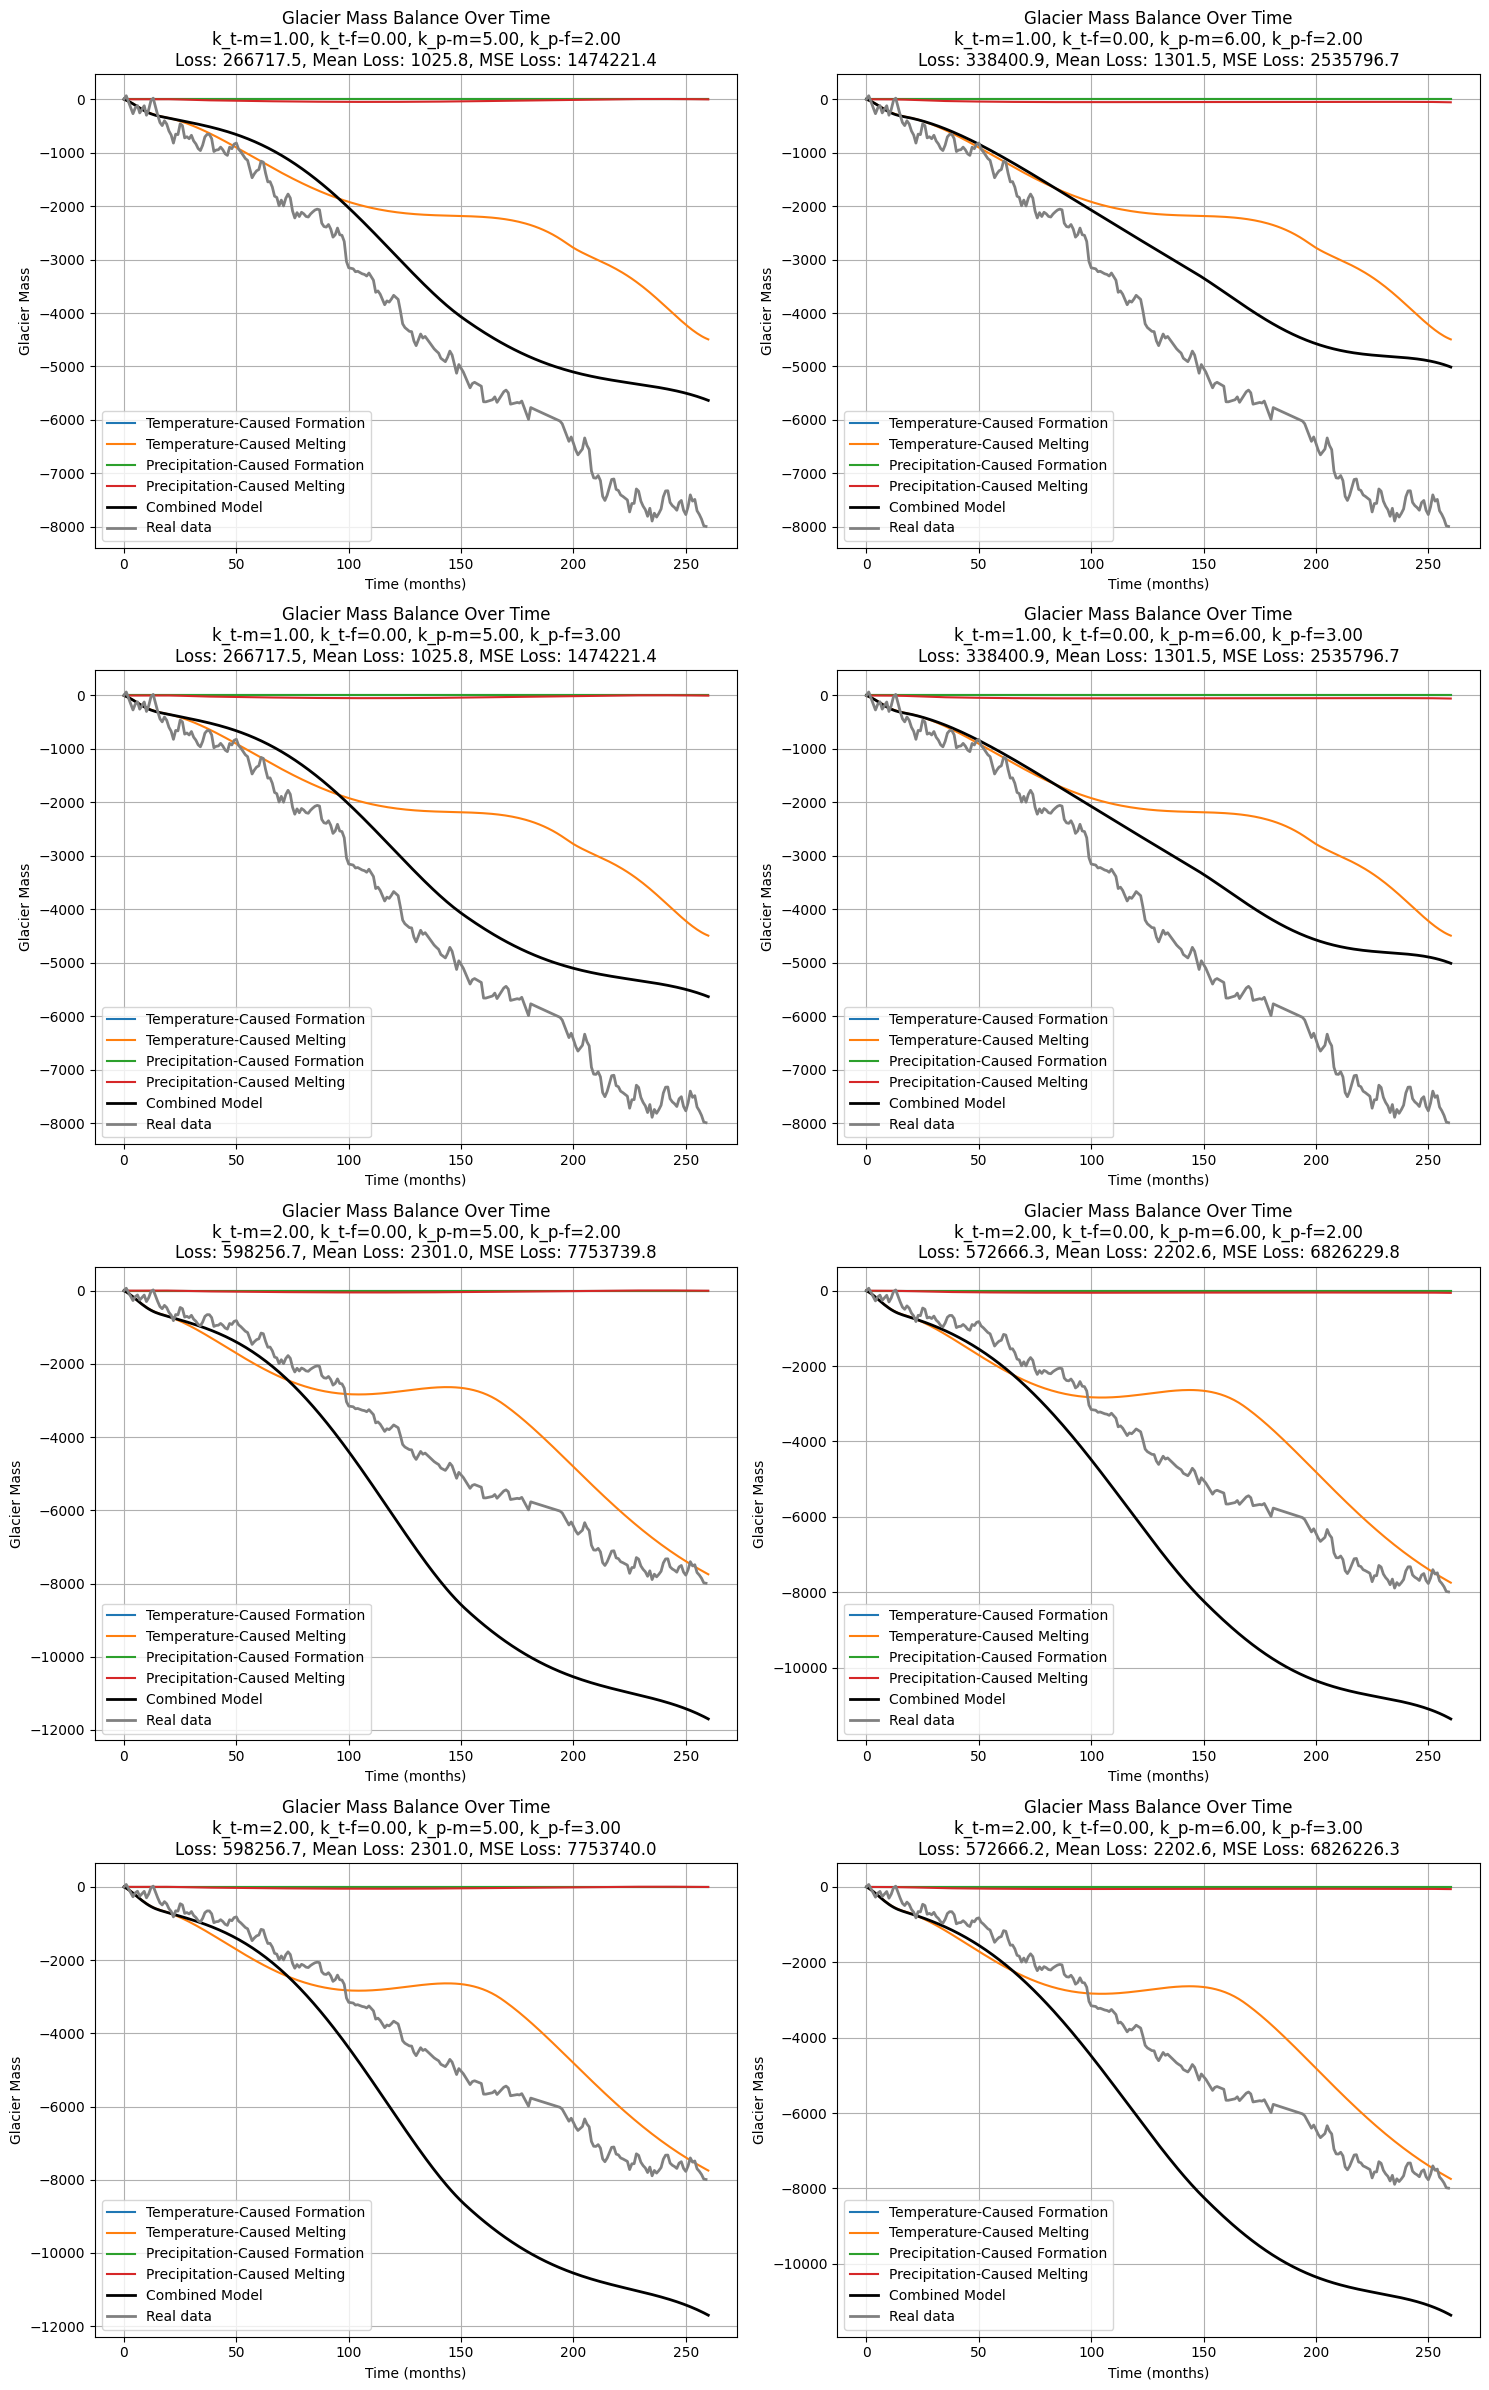

In [27]:
k_f_range = np.linspace(0, 0, 1)
k_m_range = np.linspace(1, 2, 2)
k_p_range = np.linspace(2, 3, 2)
k_pm_range = np.linspace(5, 6, 2)

num_plots = len(k_f_range) * len(k_m_range) * len(k_p_range) * len(k_pm_range)
cols = 2  # Number of columns in the plot grid
rows = (num_plots + cols - 1) // cols  # Calculate rows needed
plt.figure(figsize=(15, rows * 6))  # Adjust overall figure size as needed

all_loss = {}
plot_count = 1
for k_f in k_f_range:
    for k_m in k_m_range:
        for k_p in k_p_range:
            for k_pm in k_pm_range:
                sol_TCF, sol_TCM, sol_PCF, sol_PCM, sol_combined = solve_model(k_f, k_m, k_p, k_pm)
                
                prediction = (sol_combined.y[0] - M0).flatten().tolist()

                l = loss_function(prediction, plot_df['mass'])     
                mean_l = mean_loss_function(prediction, plot_df['mass'])                          
                mse_l = MSE_loss_function(prediction, plot_df['mass'])

                plt.subplot(rows, cols, plot_count)
                plt.plot(sol_TCF.t, sol_TCF.y[0] - M0, label='Temperature-Caused Formation')
                plt.plot(sol_TCM.t, sol_TCM.y[0] - M0, label='Temperature-Caused Melting')
                plt.plot(sol_PCF.t, sol_PCF.y[0] - M0, label='Precipitation-Caused Formation')
                plt.plot(sol_PCM.t, sol_PCM.y[0] - M0, label='Precipitation-Caused Melting')
                plt.plot(sol_combined.t, sol_combined.y[0] - M0, label='Combined Model', linewidth=2, color='black')
                plt.plot(plot_df['index'], plot_df['mass'], label='Real data', linewidth=2, color='gray')
                plt.xlabel('Time (months)')
                plt.ylabel('Glacier Mass')
                plt.title(f'Glacier Mass Balance Over Time\nk_t-m={k_m:.2f}, k_t-f={k_f:.2f}, k_p-m={k_pm:.2f}, k_p-f={k_p:.2f}\nLoss: {l:.1f}, Mean Loss: {mean_l:.1f}, MSE Loss: {mse_l:.1f}')
                plt.legend()
                plt.grid(True)
                plot_count += 1
    plt.tight_layout()
    plt.show()

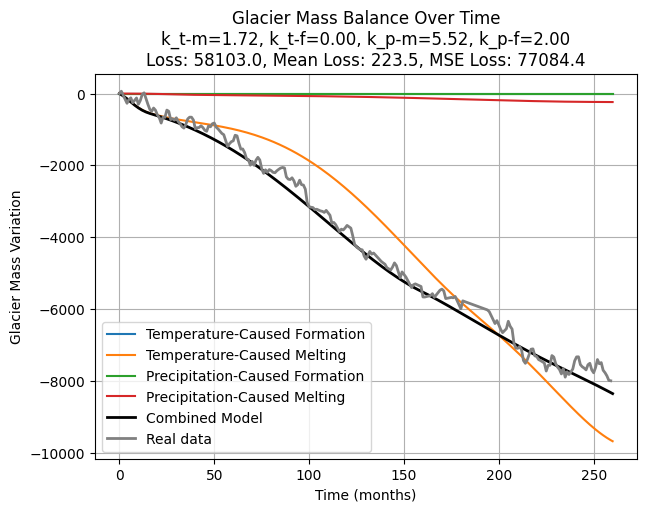

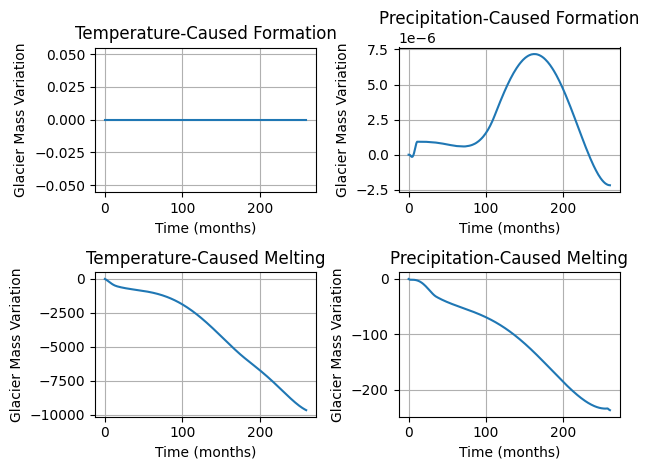

In [28]:
k_f, k_m, k_p, k_pm = 0.0, 1.7241379310344829, 2.0, 5.517241379310345


sol_TCF = solve_ivp(dMdt_TCF, t_span, M0, t_eval=t_eval)
sol_TCM = solve_ivp(dMdt_TCM, t_span, M0, t_eval=t_eval)
sol_PCF = solve_ivp(dMdt_PCF, t_span, M0, t_eval=t_eval)
sol_PCM = solve_ivp(dMdt_PCM, t_span, M0, t_eval=t_eval)
sol_combined = solve_ivp(dMdt_combined, t_span, M0, t_eval=t_eval)

prediction = (sol_combined.y[0] - M0).flatten().tolist()

l = loss_function(prediction, plot_df['mass'])     
mean_l = mean_loss_function(prediction, plot_df['mass'])                          
mse_l = MSE_loss_function(prediction, plot_df['mass'])

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(sol_TCF.t, sol_TCF.y[0] - M0, label='Temperature-Caused Formation')
plt.plot(sol_TCM.t, sol_TCM.y[0] - M0, label='Temperature-Caused Melting')
plt.plot(sol_PCF.t, sol_PCF.y[0] - M0, label='Precipitation-Caused Formation')
plt.plot(sol_PCM.t, sol_PCM.y[0] - M0, label='Precipitation-Caused Melting')
plt.plot(sol_combined.t, sol_combined.y[0] - M0, label='Combined Model', linewidth=2, color='black')
plt.plot(plot_df['index'], plot_df['mass'], label='Real data', linewidth=2, color='gray')
plt.xlabel('Time (months)')
plt.ylabel('Glacier Mass Variation')
plt.title(f'Glacier Mass Balance Over Time\nk_t-m={k_m:.2f}, k_t-f={k_f:.2f}, k_p-m={k_pm:.2f}, k_p-f={k_p:.2f}\nLoss: {l:.1f}, Mean Loss: {mean_l:.1f}, MSE Loss: {mse_l:.1f}')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(2, 2)

# Plot data on each subplot
axs[0, 0].plot(sol_TCF.t, sol_TCF.y[0] - M0)
axs[0, 0].set_title('Temperature-Caused Formation')
axs[0, 0].set_xlabel("Time (months)")
axs[0, 0].set_ylabel('Glacier Mass Variation')
axs[0, 0].grid(True)

axs[0, 1].plot(sol_PCF.t, sol_PCF.y[0] - M0)
axs[0, 1].set_title('Precipitation-Caused Formation')
axs[0, 1].set_xlabel("Time (months)")
axs[0, 1].set_ylabel('Glacier Mass Variation')
axs[0, 1].grid(True)

axs[1, 0].plot(sol_TCM.t, sol_TCM.y[0] - M0)
axs[1, 0].set_title('Temperature-Caused Melting')
axs[1, 0].set_xlabel("Time (months)")
axs[1, 0].set_ylabel('Glacier Mass Variation')
axs[1, 0].grid(True)

axs[1, 1].plot(sol_PCM.t, sol_PCM.y[0] - M0)
axs[1, 1].set_title('Precipitation-Caused Melting')
axs[1, 1].set_xlabel("Time (months)")
axs[1, 1].set_ylabel('Glacier Mass Variation')
axs[1, 1].grid(True)
fig.tight_layout()
plt.show()